# Understanding on-policy and off-policy properties 

In this part, we investigate the difference between the off-policy property of Q-learning and the on-policy property of SARSA. For doing so, we will feed the critic of these algorithms with off-policy data stored into a replay buffer.
Using a replay buffer is not mandatory when using random uniform samples, but using this approach makes the architecture more flexible for later experiments.

### Create a class Sample

A sample contains the following information : the current state, the current action, the resulting reward, and the resulting next state.

In the cell below, create a class to store a sample

In [24]:
class Sample():
    def __init__(self,x, u, r, d, y):
        self.state = x
        self.action = u
        self.reward = r
        self.done = d
        self.new_state = y

### Create a class ReplayBuffer

A replay buffer is a FIFO list of samples with a limited size (often set to 10^6). 

In the cell below, create a class ReplayBuffer. Give it a method __add(sample)__ to add a sample, a method __draw()__ to draw a sample randomly

In [25]:
import collections
import numpy as np
import copy
from dynamic_programming import *

class ReplayBuffer():

    def __init__(self, buffer_size,sample=None):
        self.buffer_size = buffer_size
        self.buffer = collections.deque(maxlen=self.buffer_size)
        if sample != None:
            for i in range(sample.shape[0]):
                self.push(sample[i])

    def push(self, sample, overwrite=True):

        """ If maximum buffer size reached , remove old experience """
        if len(self.buffer) == self.buffer_size:
            self.buffer.popleft()

        self.buffer.append(sample)

    def __len__(self):
        return len(self.buffer)

    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):

        self.n = self.n + 1

        if self.n < len(self.buffer):
            return self.buffer[self.n]

        raise StopIteration

    def uniform_sample(self, batch_size=1):
        indices = np.random.randint(0, len(self.buffer), batch_size)
        experiences = np.array([self.buffer[i] for i in indices])

        samples = []

        for exp in experiences:
            samples.append(exp)

        return np.array(samples)


    def clear(self):
        self.buffer.clear()

In your mdp class, add a method __uniformSampling()__ which returns a randomly generated sample: it draws a state and an action at random, provides the corresponding reward and next state, stores these into a sample and returns that sample.

In the box below, get your Q-learning code from [reinforcement_learning.ipynb](reinforcement_learning.ipynb), and copy-paste it.

In [26]:
import numpy as np
from toolbox import softmax

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def QLearning(mdp,replay_buffer,tau=1,nTimesteps=10000,alpha=0.01 , test_conv=False):
    if(test_conv):
        [VI_Q_list, VI_policy_list] = VI_Q(mdp,render=False)
        
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    if(test_conv):
        nb_step=0
        conv= False
    for i in range(nTimesteps) :

        # Perform a step of the MDP
        sample = replay_buffer.uniform_sample()
        x,u,r,done,y = sample[0].state, sample[0].action, sample[0].reward, sample[0].done, sample[0].new_state

        # Update the state-action value function with Q-Learning
        if x in mdp.terminal_states:
            Q[x,u] = r
        else:
            delta = r + mdp.gamma*np.max(Q[y])-Q[x,u]
            Q[x,u] = Q[x,u] + alpha*delta

        # Update agent's position
        x = y
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
        
        if(test_conv and not conv):
            nb_step+=1
            if np.linalg.norm(Q-VI_Q_list[-1])<= 0.1 :
                conv=True
                print("Step to conv ", nb_step)
                return [Q_list, policy_list]
            
    return [Q_list, policy_list]

Modify the above code so that, instead of being fed by the samples of an agent running its current policy, the Q-table is fed by samples drawn randomly from the replay buffer.


### Writing the main code
 
 Below, write a code that:
 * creates a replay buffer containing 10.000 samples drawn uniformly from the mdp,
 * makes Q-learning learn from samples drawn uniformly from the replay buffer for a fixed number of episodes,
 * visualizes the results.


In [29]:
from mdp import maze_mdp

walls = [6,17,18,19]
height = 5
width = 5
m = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1]) # maze-like MDP definition

replay_buffer = ReplayBuffer(10000)
for _ in range(10000):
    x = m.reset(uniform=True)
    u = m.action_space.sample()
    [y,r,done,info] = m.step(u)
    sample = Sample(x,u,r,done,y)
    replay_buffer.push(sample)
    
Qlist, policy_list = QLearning(m,replay_buffer,tau=1,nTimesteps=200000,alpha=0.01, test_conv=True)

Step to conv  129100


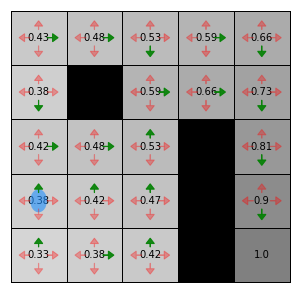

In [30]:
from maze_plotter import maze_plotter

m.new_render()
m.render(Qlist[-1], policy_list[-1])

What do you observe? Is this algorithm converging to an optimal Q-table?

Now, do the same with SARSA: import it below, and modify it as you did for Q-learning (or just change your modified Q-learning into a modified SARSA below, this is easier).


In [31]:
import numpy as np
from toolbox import softmax

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def Sarsa(mdp,replay_buffer, epsilon=0.1,nEpisodes=100000,nTimesteps=50,alpha=0.01,test_conv=False, render=True):
    if(test_conv):
        [VI_Q_list, VI_policy_list] = VI_Q(mdp,render=False)
        
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
    if(test_conv):
        nb_step=0
        conv= False
    for i in range(nEpisodes) :
        #Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True) 
        if render :
            # Show the agent in the maze
            mdp.render(Q, Q.argmax(axis=1))

        # Draw an action using a e-greedy policy
        #prob_list = np.ones(len(mdp.action_space.actions))
        #prob_list *= epsilon/(len(mdp.action_space.actions)-1)
        #prob_list[np.argmax(Q[x])] = 1-epsilon
        #u = mdp.action_space.sample(prob_list=prob_list)

        # Draw an action using a soft-max policy
        #u = mdp.action_space.sample(prob_list=softmax(Q,x,tau))

        # Perform a step of the MDP
        sample = replay_buffer.uniform_sample()
        x,u,r,done,y = sample[0].state, sample[0].action, sample[0].reward, sample[0].done, sample[0].new_state
        #[y,r,done,info] = mdp.step(u)

        # Update the state-action value function with Q-Learning
        if x in mdp.terminal_states:
            Q[x,u] = r
        else:
            #e_greedy
            prob_list = np.ones(len(mdp.action_space.actions))
            prob_list *= epsilon/(len(mdp.action_space.actions)-1)
            prob_list[np.argmax(Q[y])] = 1-epsilon
            u_prime = mdp.action_space.sample(prob_list=prob_list)
            #softmax
            #u_prime = mdp.action_space.sample(prob_list=softmax(Q,y,tau))

            delta = r + mdp.gamma*Q[y,u_prime]-Q[x,u]
            Q[x,u] = Q[x,u] + alpha*delta

        # Update agent's position
        x = y
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
        if(test_conv and not conv):
            nb_step+=1
            if np.linalg.norm(Q-VI_Q_list[-1])<= 0.1 :
                conv=True
                print("Step to conv ", nb_step)
                return [Q_list, policy_list]
            
    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

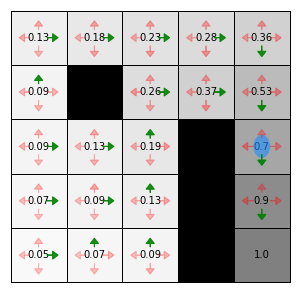

In [33]:
from mdp import maze_mdp

walls = [6,17,18,19]
height = 5
width = 5
m = maze_mdp(width, height,  walls=walls, terminal_states=[height*width-1]) # maze-like MDP definition

replay_buffer = ReplayBuffer(10000)
for _ in range(10000):
    x = m.reset(uniform=True)
    u = m.action_space.sample()
    [y,r,done,info] = m.step(u)
    sample = Sample(x,u,r,done,y)
    replay_buffer.push(sample)
    
Qlist, policy_list = Sarsa(m,replay_buffer,nEpisodes=200000,epsilon = 0.5, render=False)
m.new_render()
m.render(Qlist[-1], policy_list[-1])

Again, what do you observe? Is this algorithm converging to an optimal Q-table?
Discuss the difference.
To go further and better understand the convergence properties of SARSA, read [the paper where its convergence was proven](https://link.springer.com/content/pdf/10.1023/A:1007678930559.pdf)